Flow with fracture:)


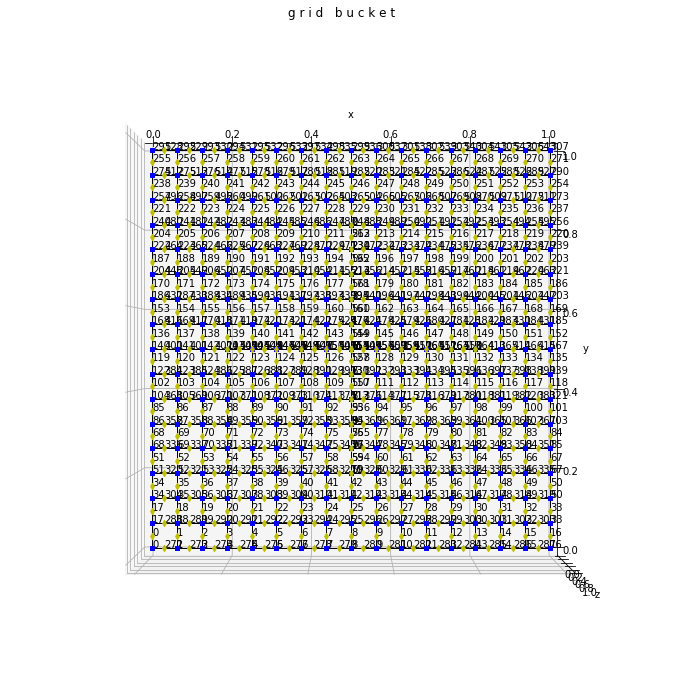

In [1]:
import porepy as pp
import numpy as np
import scipy.sparse as sps

Nx = Ny = 16

gb,_ = pp.grid_buckets_2d.two_intersecting(mesh_args=[Nx,Ny],x_endpoints=[0.2,0.8],y_endpoints=[0.2,0.8], simplex=False)
# gb,_ = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)

pp.plot_grid(gb,info = 'fn',alpha=0,figsize=(12,15))

gb.compute_geometry()

Data and stuff

In [7]:
aperture = 1e-3
fracture_perm = 1e-5

for g,d in gb:
    # Permeability
    k = np.ones(g.num_cells)
    if g.dim == 2:
        k *= 0.1
    perm = pp.SecondOrderTensor(k)
    
    specific_volumes = np.power(aperture, gb.dim_max()-g.dim)
    
    # Boundary conditions

    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
    bc_val = np.zeros(g.num_faces)

    bc_val[b_faces] = np.ones(g.face_centers[1, b_faces].size)
    
    f = 1e-2* g.cell_volumes * specific_volumes

    specified_parameters = {'second_order_tensor': perm,'source':f, 'bc':bc,'bc_values':bc_val}
#     specified_parameters = {'second_order_tensor': perm, 'bc':bc,'bc_values':bc_val}
    data = pp.initialize_data(g,d,'flow',specified_parameters)
data_key = 'flow'
for e,d in gb.edges():
    gl, _ = gb.nodes_of_edge(e)
    mg = d["mortar_grid"]
    # Division through aperture/2 may be thought of as taking the gradient, i.e.
    # dividing by the distance from the matrix to the center of the fracture.
    kn = fracture_perm / (aperture/2)
    pp.initialize_data(mg, d, data_key, {"normal_diffusivity": kn})

    

In [8]:
data_key = 'flow'
flow_discretization = pp.Tpfa(data_key)
source_discretization = pp.ScalarSource(data_key)

for g, d in gb:
        d[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1}}
        d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization,"source": source_discretization}}
#         d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization}}
        
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)

for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
    d[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            g1: ("pressure", "diffusive"),
            g2: ("pressure", "diffusive"),
            e: ("mortar_flux", flow_coupling_discretization),
        }
    }

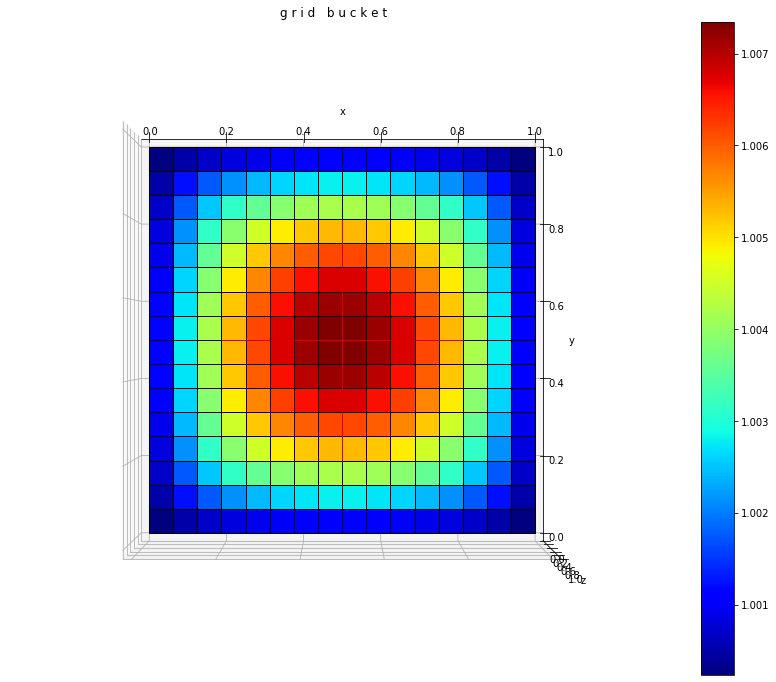

In [9]:
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
solution = sps.linalg.spsolve(A, b)
assembler.distribute_variable(solution)

pp.plot_grid(gb, "pressure",figsize=(15, 12))